In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
! python --version

Python 3.10.9


In [55]:
import pandas as pd
import numpy as np
import tensorflow 
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import models,layers,activations,losses,optimizers,metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [56]:
df = pd.read_csv('C:/Users/HP/dataset/creditcard.csv')

In [57]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [59]:
df.columns.values

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [60]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

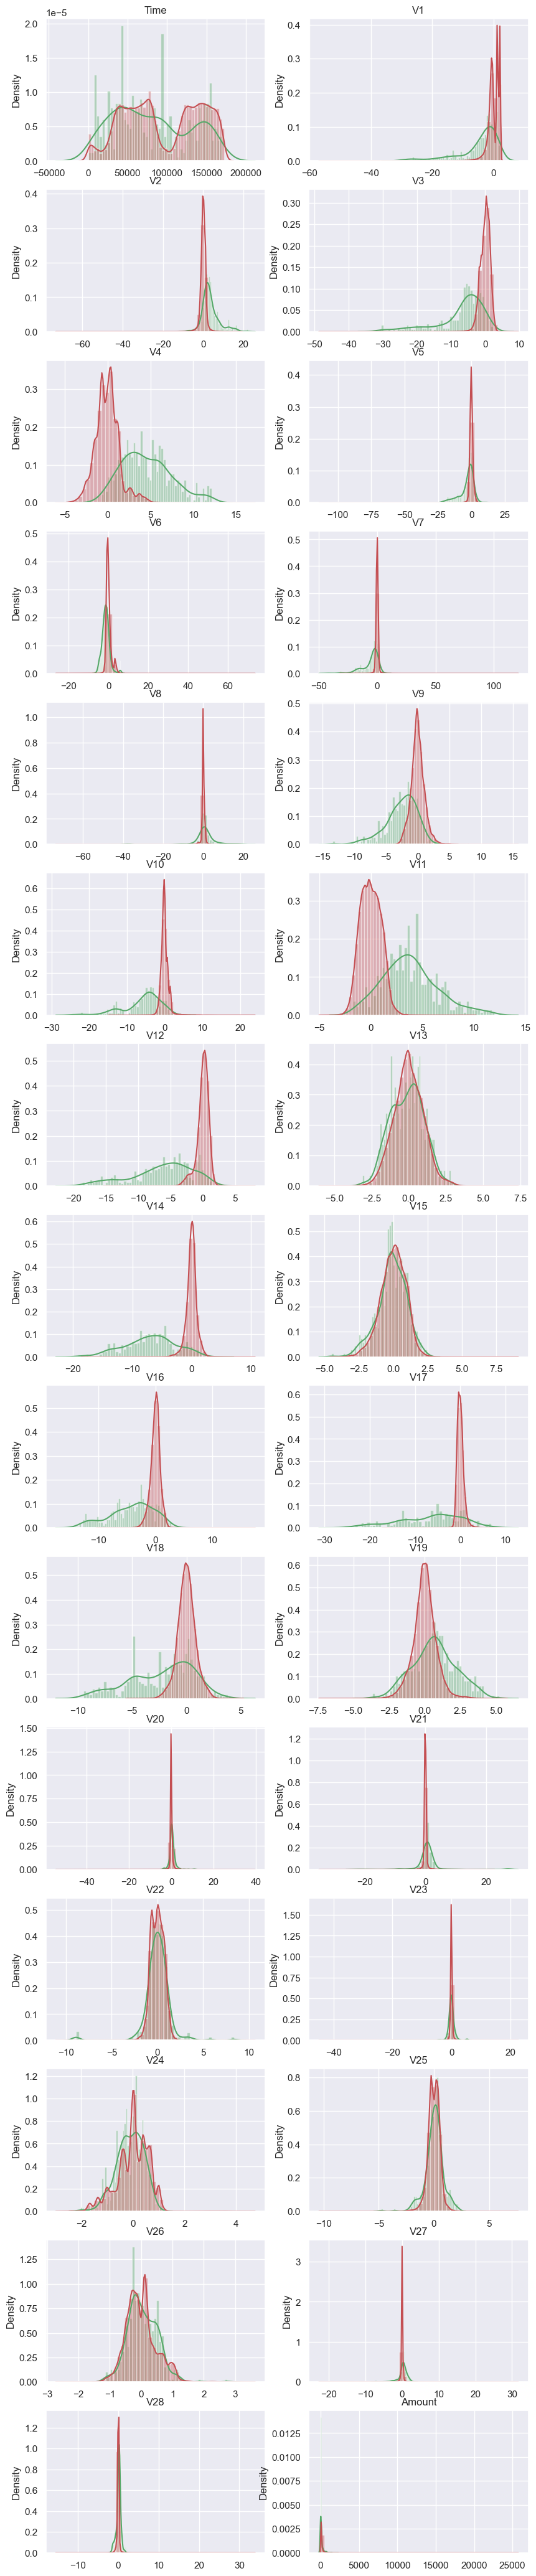

In [61]:
import matplotlib.gridspec as gridspec
columns  = df.iloc[:,df.columns  != 'Class'].columns
frauds = df.Class == 1
normals = df.Class == 0
grid = gridspec.GridSpec(17, 2)
plt.figure(figsize=(10,15*4))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[col][frauds], bins = 50, color='g')
    sns.distplot(df[col][normals], bins = 50, color='r')
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()

In [63]:
df_selected = df.drop(['V15','V22','V27','V28','Time'], axis = 1)
df_selected.shape

(284807, 26)

In [11]:
df_training, df_testing = train_test_split(df_selected,test_size = 0.2, random_state = 42,stratify = df_selected.Class)
df_testing.Class.value_counts()

0    56864
1       98
Name: Class, dtype: int64

In [12]:
train_data,validation_data,train_lable, validation_lable = train_test_split(df_training.loc[:,df_training.columns != 'Class'],df_training.Class,test_size = 0.2, stratify  = df_training.Class,
                                                random_state = 42) 

In [13]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit(train_data)
train_data_normalised = data_scaled.transform(train_data)
validation_data_normalised = data_scaled.transform(validation_data)

In [14]:
test_data = df_testing.loc[:, df_testing.columns != 'Class']
test_lable = df_testing.Class
test_data_normalised = data_scaled.transform(test_data)

In [15]:
test_data.shape

(56962, 25)

In [16]:
train_data_normalised.shape

(182276, 25)

In [17]:
train_lable,validation_lable, test_lable = train_lable.astype(bool), validation_lable.astype(bool), test_lable.astype(bool)

In [18]:
normal_train_data = train_data_normalised[~train_lable]
normal_test_data = test_data_normalised[~test_lable]
normal_validation_data = validation_data_normalised[~validation_lable]

In [19]:
print(len(normal_train_data))
print(len(normal_test_data))
print(len(normal_validation_data))

181961
56864
45490


In [20]:
fraud_train_data = train_data_normalised[train_lable]
fraud_test_data = test_data_normalised[test_lable]
fraud_validation_data = validation_data_normalised[validation_lable]

In [21]:
print(len(fraud_train_data))
print(len(fraud_test_data))
print(len(fraud_validation_data))

315
98
79


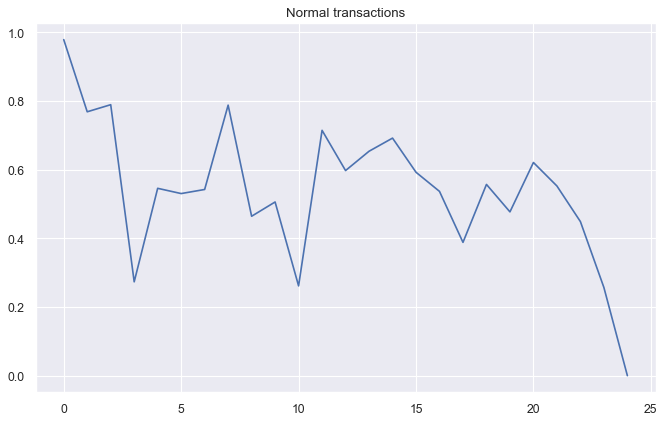

In [25]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)
plt.plot(np.arange(25), normal_train_data[1])
plt.title('Normal transactions')

plt.show()

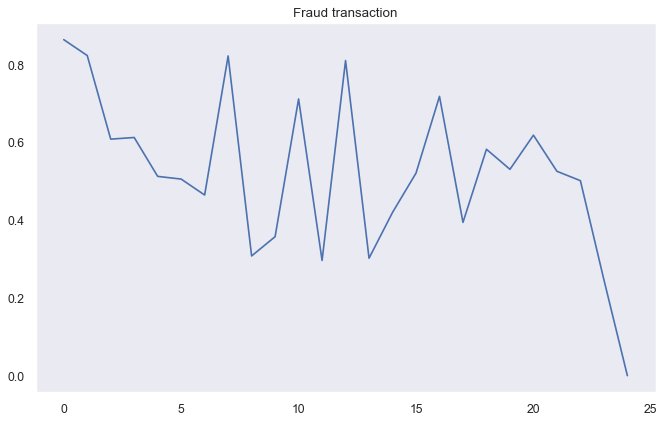

In [26]:
#Lets plot one from fraud transaction
figure(figsize=(10, 6), dpi=80)

plt.plot(np.arange(25), fraud_train_data[2])
plt.grid()
plt.title('Fraud transaction')
plt.show()

In [24]:
n_features = len(train_data.columns)
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=200, activation=activations.relu, input_shape=[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=100, activation=activations.relu))
encoder.add(layer=layers.Dense(units=5, activation=activations.relu))
encoder.summary()

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=100, activation=activations.relu, input_shape=[5]))
decoder.add(layer=layers.Dense(units=200, activation=activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))
decoder.summary()

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(loss=losses.MSE,optimizer=optimizers.Adam(),metrics=[metrics.mean_squared_error])
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 200)               5200      
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_13 (Dense)            (None, 100)               20100     
                                                                 
 dense_14 (Dense)            (None, 5)                 505       
                                                                 
Total params: 25,805
Trainable params: 25,805
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10

Epoch 1/100
5687/5687 [==============================] - 15s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 7.1450e-04 - val_mean_squared_error: 7.1450e-04
Epoch 2/100
5687/5687 [==============================] - 13s 2ms/step - loss: 6.9320e-04 - mean_squared_error: 6.9320e-04 - val_loss: 5.9932e-04 - val_mean_squared_error: 5.9932e-04
Epoch 3/100
5687/5687 [==============================] - 13s 2ms/step - loss: 6.1936e-04 - mean_squared_error: 6.1936e-04 - val_loss: 5.4734e-04 - val_mean_squared_error: 5.4734e-04
Epoch 4/100
5687/5687 [==============================] - 14s 2ms/step - loss: 5.8521e-04 - mean_squared_error: 5.8521e-04 - val_loss: 5.1567e-04 - val_mean_squared_error: 5.1567e-04
Epoch 5/100
5687/5687 [==============================] - 13s 2ms/step - loss: 5.6187e-04 - mean_squared_error: 5.6187e-04 - val_loss: 4.9452e-04 - val_mean_squared_error: 4.9452e-04
Epoch 6/100
5687/5687 [==============================] - 14s 2ms/step - loss: 5.4530e-04 - mean_sq

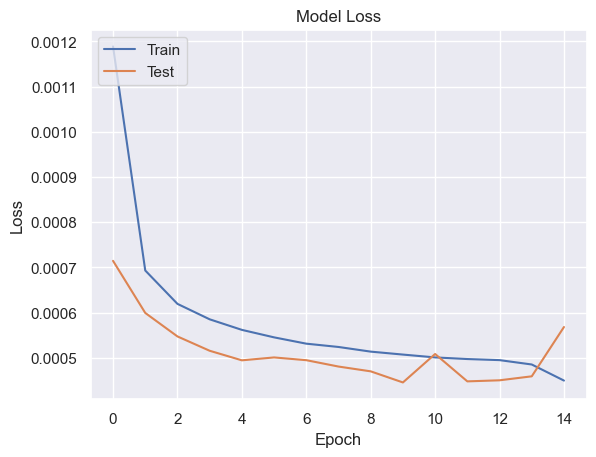

In [25]:
# train model
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5,restore_best_weights=True)
history = autoencoder.fit(x=normal_train_data, y=normal_train_data, epochs=100, verbose=1, validation_data=(normal_validation_data, normal_validation_data), callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1777/1777 [==============================] - 2s 1ms/step


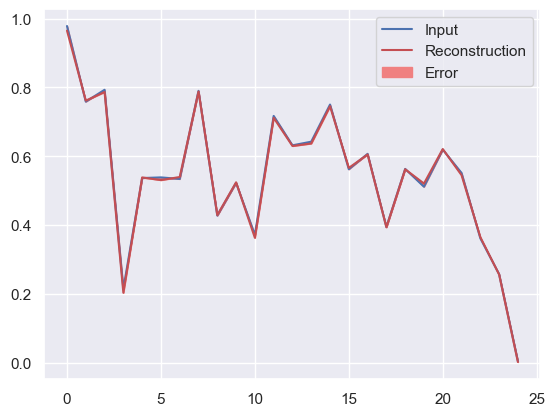

4/4 [==============================] - 0s 1ms/step


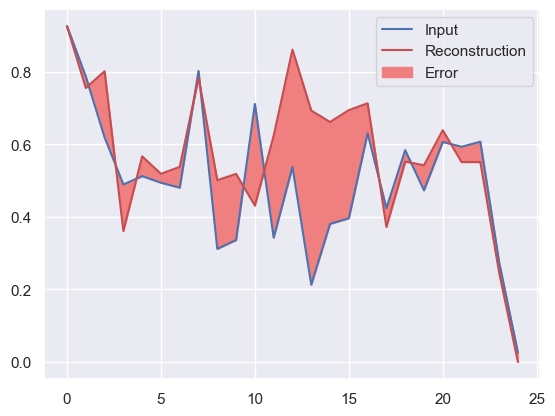

In [28]:
def plot(data, n):
    dec_img = autoencoder.predict(data)
    plt.plot(data[n], 'b')
    plt.plot(dec_img[n], 'r')
    plt.fill_between(np.arange(25), data[n], dec_img[n])
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.show()

plot(normal_test_data, 9) 
plot(fraud_test_data, 9)


In [30]:
### calculating the train error  in legit transactions
reconstructed = autoencoder.predict(normal_train_data)
train_normal_loss = losses.mae(reconstructed, normal_train_data).numpy()
np.mean(train_normal_loss)

5687/5687 [==============================] - 5s 897us/step


0.01149498212096092

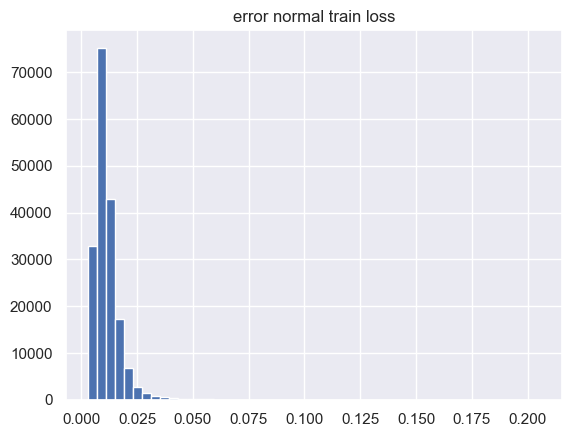

In [31]:
plt.hist(train_normal_loss, bins = 50)
plt.title('error normal train loss')
plt.show()

10/10 [==============================] - 0s 1ms/step
0.06063163360966158


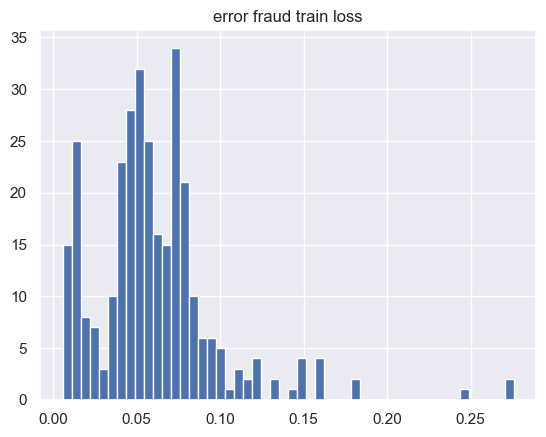

In [32]:
reconstructed = autoencoder.predict(fraud_train_data)
train_fraud_loss = losses.mae(reconstructed, fraud_train_data).numpy()
print(np.mean(train_fraud_loss))
plt.hist(train_fraud_loss, bins = 50)
plt.title('error fraud train loss')
plt.show()

In [34]:
reconstructed = autoencoder.predict(train_data_normalised)
train_loss = losses.mae(reconstructed, train_data_normalised).numpy()

5697/5697 [==============================] - 6s 1ms/step


In [50]:
# threshold calculation at 99th percentile of training loss
cut_off_1 = np.percentile(train_loss, 99)
cut_off_1

0.03997757338191868

4/4 [==============================] - 0s 1ms/step


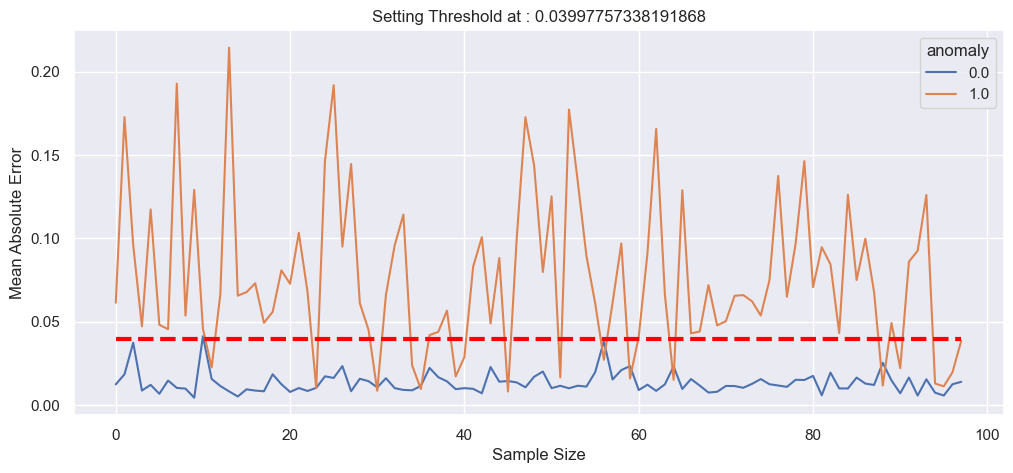

In [44]:
from matplotlib import lines
plot_samples = 98 # fraud test count
plt.figure(figsize=(12,5))

# normal payment
n_features = 25
real_x = normal_test_data[:plot_samples]
predicted_x = autoencoder.predict(x=real_x)
normal_events_mae = losses.mae(real_x, predicted_x)
normal_events_df = pd.DataFrame({'Mean Absolute Error': normal_events_mae,'Sample Size': np.arange(0, plot_samples),'anomaly': np.zeros(plot_samples)})


# fraud payment
abnormal_x = fraud_test_data[:plot_samples]
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mae = losses.mae(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({'Mean Absolute Error': abnormal_events_mae,'Sample Size': np.arange(0, plot_samples),'anomaly': np.ones(plot_samples)})
abnormal_events_df

mae_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mae_df['Sample Size'], y=mae_df['Mean Absolute Error'], hue=mae_df.anomaly)

line = lines.Line2D(xdata=np.arange(0, plot_samples),ydata=np.full(plot_samples, cut_off_1),color='red',linewidth=3,linestyle='dashed')

plot.add_artist(line)
plt.title('Setting Threshold at : {threshold}'.format(threshold=cut_off_1))
plt.show()
